# Keras Classification

In [2]:
#!pip install pyforest
# 1-Import Libraies

#!pip install lightgbm
#!pip install catboost

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#Model Selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict

#Feature Selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBClassifier
from xgboost import plot_importance

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPRegressor

#Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


#Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

#Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#!pip install termcolor
from termcolor import colored
import missingno as msno 


In [3]:
## Useful Functions

###############################################################################

def first_looking(column):
    print("column name    : ", column) 
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[column].isnull().sum())
    print("num_of_uniques : ", df[column].nunique())
    print("value_counts : ", df[column].value_counts(dropna = False).head())
    
# for i in df.columns:
#     first_looking(i)

###############################################################################

def perc_nans(serial):  # Ex:perc_nans(df['kW'])
    # display percentage of nans in a Series
    return serial.isnull().sum()/serial.shape[0]*100

def perc_nans_byLimitless(df):
    return df.isnull().sum()/df.shape[0]*100

def perc_nans_byLimit(df, limit):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x >= limit]

# perc_nans_byLimit(df, 90)

###############################################################################

def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('-'*79, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')

    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    
        
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .9 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('-'*79, 'red', attrs=['bold']), sep='')

def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored("Duplicates were dropped!"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')     
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary will drop realted columns!', attrs=['bold']),'\n',
              colored('-'*79, 'red', attrs=['bold']), sep='')
        
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print('New shape after missing value control:', df.shape)

###############################################################################

# 3-Target Examination
def target_examination(df):

    print(colored('-'*79, 'red', attrs=['bold']), '\n',
          colored(f"Target(y): ", 'blue', attrs=['bold']), target, 
          colored(f"\nValue Counts:\n", attrs=['bold']), df[target].value_counts(),'\n',
          colored(f"Class {df[target].value_counts().index[0]}:", attrs=['bold']), round(df[target].value_counts(normalize=True)[0]*100,2), '%\n',
          colored(f"Class {df[target].value_counts().index[1]}:", attrs=['bold']), round(df[target].value_counts(normalize=True)[1]*100,2), '%\n',
          colored('-'*79, 'red', attrs=['bold']), '\n',
          colored(f"Target Skewness: ", attrs=['bold']), round(df[target].skew(), 2), '\n',
          colored(f"Target Kurtosis: ", attrs=['bold']), round(df[target].kurtosis(), 2), '\n', 
          colored('-'*79, 'red', attrs=['bold']), sep='')

    X_columns = df.drop(target, axis=1).columns
    X_numerical = df.drop(target, axis=1).select_dtypes('number').astype('float64')
    X_categorical = df.drop(target, axis=1).select_dtypes('object')

    print(colored(f"Features: ", 'blue', attrs=['bold']), list(X_columns),'\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored(f"Numerical Features: ", 'blue', attrs=['bold']), list(X_numerical.columns), '\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored(f"Categorical Features: ", 'blue', attrs=['bold']), list(X_categorical.columns), '\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored(f"Number of Uniques in Categorical Columns: ", 'blue', attrs=['bold']), '\n', X_categorical.nunique(), '\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')
    print(colored(f"Saved variables: ", 'blue', attrs=['bold']),
          colored(f"[target, X_columns, X_numerical, X_categorical]", attrs=['bold']), '\n',
          colored('-'*79, 'red', attrs=['bold']), sep='')

def features(df, target):
    target = target
    X_columns = df.drop(target, axis=1).columns
    X_numerical = df.drop(target, axis=1).select_dtypes('number').astype('float64')
    X_categorical = df.drop(target, axis=1).select_dtypes('object')
    return target, X_columns, X_numerical, X_categorical
    

###############################################################################

def fill_median(df, group_col, col_name):
    '''Fills the missing values with the most existing value (median) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        median = list(df[cond][col_name].median())
        if median != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].median()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].median()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def model_validation(y_train, y_train_pred, y_test, y_test_pred, model_name):
    
    scores =  {f"{model_name}_train": {"R2" : r2_score(y_train, y_train_pred),
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "mse" : mean_squared_error(y_train, y_train_pred), 
    "mae" : mean_absolute_error(y_train, y_train_pred)},
    
    f"{model_name}_test": {"R2" : r2_score(y_test, y_test_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "mse" : mean_squared_error(y_test, y_test_pred),
    "mae" : mean_absolute_error(y_test, y_test_pred)}}
     
    return pd.DataFrame(scores)

# lm = model_validation(y_train, y_train_pred, y_test, y_test_pred, 'lm')

# pd.concat([lm, rs, rcvs, lss, lcvs, es, ecvs], axis = 1)

###############################################################################

def get_classification_report(y_test, y_test_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_test_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)
    try:
        print('y_test_pred.shape:', y_test_pred.shape)
    except:
        print()
        
###############################################################################

def calc_predict():
    return accuracy_score(y_test, y_test_pred), recall_score(y_test, y_test_pred, average='weighted'), f1_score(y_test, y_test_pred, average='weighted')
    
def get_report():
    from sklearn import metrics
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    y_train_pred = model.predict(X_train_scaled)
    try:
        y_train_pred_proba = model.predict_proba(X_train_scaled)
    except:
        print()
    try:
        precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba[:,1])
    except:
        print() 
    try:
        y_test_pred_proba = model.predict_proba(X_test_scaled)
    except:
        print()
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba[:,1])
    except:
        print()  
    print('Model:', model.get_params, '\n')
    try:
        print('model.best_params_:', model.best_params_, '\n')
    except:
        print()
    print("Train:")
    print('rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('accuracy:', accuracy_score(y_train, y_train_pred))
    try:
        print('roc_auc_score:',roc_auc_score(y_train, y_train_pred_proba[:,1]))
    except:
        print()
    try:
        print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    except:
        print()
    print('confusion_matrix:\n\n', confusion_matrix(y_train, y_train_pred), '\n')
    print('classification_report:\n\n', classification_report(y_train, y_train_pred),'\n')
    print()
    print("Test:")
    print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred))) 
    print('accuracy:', accuracy_score(y_test, y_test_pred))
    try:
        print('roc_auc_score:',roc_auc_score(y_test, y_test_pred_proba[:,1]))
    except:
        print() 
    try:
        print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    except:
        print() 
    print('confusion_matrix:\n\n', confusion_matrix(y_test, y_test_pred), '\n')
    print('classification_report:\n\n', classification_report(y_test, y_test_pred))

def train_control_table():
    y_train_pred = model.predict(X_train_scaled)
    y_train_pred = pd.DataFrame(y_train_pred)
    y_train_pred.rename(columns = {0: 'y_train_pred'}, inplace = True)
    return pd.concat([X_train, y_train, y_train_pred.set_index(y_train.index)], axis=1)

def test_control_table():
    y_test_pred = model.predict(X_test_scaled)
    y_test_pred = pd.DataFrame(y_test_pred)
    y_test_pred.rename(columns = {0: 'y_test_pred'}, inplace = True)
    return pd.concat([X_test, y_test, y_test_pred.set_index(y_test.index)], axis=1)

def get_roc_curve():
    from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
    plot_roc_curve(model, X_train_scaled, y_train);
    plot_precision_recall_curve(model, X_train_scaled, y_train);

    plot_roc_curve(model, X_test_scaled, y_test);
    plot_precision_recall_curve(model, X_test_scaled, y_test);
    
def visualizer(model):
    from yellowbrick.classifier import ClassPredictionError
    visualizer = ClassPredictionError(model)
    # Fit the training data to the visualizer
    visualizer.fit(X_train_scaled, y_train)
    # Evaluate the model on the test data
    visualizer.score(X_test_scaled, y_test)
    # Draw visualization
    visualizer.poof();
    
###############################################################################

def feature_importances():
    df_fi = pd.DataFrame(index=X.columns, 
                         data=model.feature_importances_, 
                         columns=["Feature Importance"]).sort_values("Feature Importance")

    return df_fi.sort_values(by="Feature Importance", ascending=False).T

def feature_importances_bar():
    df_fi = pd.DataFrame(index=X.columns, 
                         data=model.feature_importances_, 
                         columns=["Feature Importance"]).sort_values("Feature Importance")
    sns.barplot(data = df_fi, 
                x = df_fi.index, 
                y = 'Feature Importance', 
                order=df_fi.sort_values('Feature Importance', ascending=False).reset_index()['index'])
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show();
    
    
    
###############################################################################

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = stats.zscore(df[col].dropna())
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile_threshold)

def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.5, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.distplot(df[col], kde=False, bins = 50)
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step)
    plt.show()

###############################################################################

def plot_multiclass_roc(model, X_test_scaled, y_test, n_classes, figsize=(5,5)):
    y_score = model.decision_function(X_test_scaled)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    
    
def plot_multiclass_roc_for_tree(model, X_test_scaled, y_test, n_classes, figsize=(5,5)):
    y_score = model.predict_proba(X_test_scaled)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Load | Read Data

In [4]:
# 2-Load|Read Data
csv_path = "Churn_Modelling.csv"
df0 = pd.read_csv(csv_path)
df = df0.copy() 
first_looking(df)
multicolinearity_control(df)
duplicate_values(df)
drop_columns(df,[])
drop_null(df, 90)
# df.head()
# df.describe().T

Shape:(10000, 14)
-------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usag

## Exploratory Data Analysis and Visualization

### Check features and drop unnecessary ones

In [6]:
df.head(3)

rownumber  customerid   surname  creditscore geography  gender  age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   

   tenure    balance  numofproducts  hascrcard  isactivemember  \
0       2      0.000              1          1               1   
1       1  83807.860              1          0               1   
2       8 159660.800              3          1               0   

   estimatedsalary  exited  
0       101348.880       1  
1       112542.580       0  
2       113931.570       1

In [7]:
df.describe().T

count         mean       std          min          25%  \
rownumber       10000.000     5000.500  2886.896        1.000     2500.750   
customerid      10000.000 15690940.569 71936.186 15565701.000 15628528.250   
creditscore     10000.000      650.529    96.653      350.000      584.000   
age             10000.000       38.922    10.488       18.000       32.000   
tenure          10000.000        5.013     2.892        0.000        3.000   
balance         10000.000    76485.889 62397.405        0.000        0.000   
numofproducts   10000.000        1.530     0.582        1.000        1.000   
hascrcard       10000.000        0.706     0.456        0.000        0.000   
isactivemember  10000.000        0.515     0.500        0.000        0.000   
estimatedsalary 10000.000   100090.240 57510.493       11.580    51002.110   
exited          10000.000        0.204     0.403        0.000        0.000   

                         50%          75%          max  
rownumber           5000.500     7500.250    10000.000  
customerid      15690738.000 15753233.750 15815690.000  
creditscore          652.000      718.000      850.000  
age                   37.000       44.000       92.000  
tenure                 5.000        7.000       10.000  
balance            97198.540   127644.240   250898.090  
numofproducts          1.000        2.000        4.000  
hascrcard              1.000        1.000        1.000  
isactivemember         1.000        1.000        1.000  
estimatedsalary   100193.915   149388.247   199992.480  
exited                 0.000        0.000        1.000

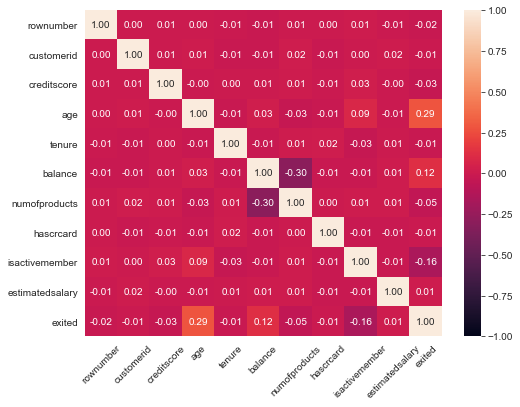

In [125]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1)
plt.xticks(rotation=45);
# Before deeping into the analysis it would be benefical to examine the correlation among variables using heatmap.

In [10]:
df.shape

(10000, 14)

In [11]:
drop_list = ["rownumber", "customerid", "surname"]

In [12]:
drop_columns(df, drop_list)

['rownumber', 'customerid', 'surname'] were dropped


In [13]:
df.shape

(10000, 11)

### Target Examination

In [56]:
target="exited"
target, X_columns, X_numerical, X_categorical = features(df, target)
target_examination(df)

-------------------------------------------------------------------------------
Target(y): exited
Value Counts:
0    7963
1    2037
Name: exited, dtype: int64
Class 0:79.63%
Class 1:20.37%
-------------------------------------------------------------------------------
Target Skewness: 1.47
Target Kurtosis: 0.17
-------------------------------------------------------------------------------
Features: ['rownumber', 'customerid', 'surname', 'creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
-------------------------------------------------------------------------------
Numerical Features: ['rownumber', 'customerid', 'creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
-------------------------------------------------------------------------------
Categorical Features: ['surname', 'geography', 'gender']
--------------------------------------------------

0    7963
1    2037
Name: exited, dtype: int64


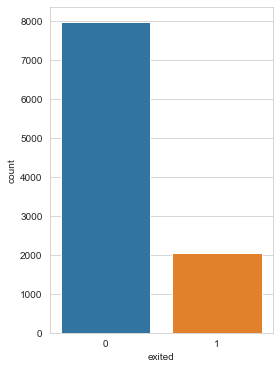

In [88]:
plt.figure(figsize = (4,6))
print(df[target].value_counts())
sns.countplot(df[target]);

0    7963
1    2037
Name: exited, dtype: int64


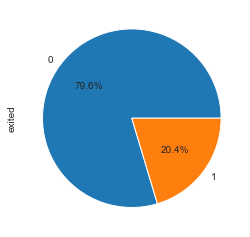

In [89]:
print(df[target].value_counts())
df[target].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(4,6));

In [92]:
df[target].describe()

count   10000.000
mean        0.204
std         0.403
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: exited, dtype: float64

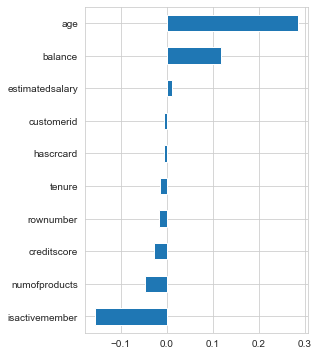

In [87]:
plt.figure(figsize = (4,6))
df.corr()[target].sort_values().drop(target).plot(kind = "barh");

In [110]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[df[target]==0].describe().T

count        mean      std         min         25%  \
rownumber       7963.00     5024.69  2891.68        2.00     2526.50   
customerid      7963.00 15691167.88 71744.23 15565701.00 15628818.50   
creditscore     7963.00      651.85    95.65      405.00      585.00   
age             7963.00       37.41    10.13       18.00       31.00   
tenure          7963.00        5.03     2.88        0.00        3.00   
balance         7963.00    72745.30 62848.04        0.00        0.00   
numofproducts   7963.00        1.54     0.51        1.00        1.00   
hascrcard       7963.00        0.71     0.46        0.00        0.00   
isactivemember  7963.00        0.55     0.50        0.00        0.00   
estimatedsalary 7963.00    99738.39 57405.59       90.07    50783.49   
exited          7963.00        0.00     0.00        0.00        0.00   

                        50%         75%         max  
rownumber           5042.00     7525.50    10000.00  
customerid      15691543.00 15753352.50 15815690.00  
creditscore          653.00      718.00      850.00  
age                   36.00       41.00       92.00  
tenure                 5.00        7.00       10.00  
balance            92072.68   126410.28   221532.80  
numofproducts          2.00        2.00        3.00  
hascrcard              1.00        1.00        1.00  
isactivemember         1.00        1.00        1.00  
estimatedsalary    99645.04   148609.96   199992.48  
exited                 0.00        0.00        0.00

In [111]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[df[target]==1].describe().T

count        mean      std         min         25%  \
rownumber       2037.00     4905.92  2866.86        1.00     2419.00   
customerid      2037.00 15690051.96 72692.62 15565706.00 15627360.00   
creditscore     2037.00      645.35   100.32      350.00      578.00   
age             2037.00       44.84     9.76       18.00       38.00   
tenure          2037.00        4.93     2.94        0.00        2.00   
balance         2037.00    91108.54 58360.79        0.00    38340.02   
numofproducts   2037.00        1.48     0.80        1.00        1.00   
hascrcard       2037.00        0.70     0.46        0.00        0.00   
isactivemember  2037.00        0.36     0.48        0.00        0.00   
estimatedsalary 2037.00   101465.68 57912.42       11.58    51907.72   
exited          2037.00        1.00     0.00        1.00        1.00   

                        50%         75%         max  
rownumber           4871.00     7404.00     9999.00  
customerid      15688963.00 15753092.00 15815656.00  
creditscore          646.00      716.00      850.00  
age                   45.00       51.00       84.00  
tenure                 5.00        8.00       10.00  
balance           109349.29   131433.33   250898.09  
numofproducts          1.00        2.00        4.00  
hascrcard              1.00        1.00        1.00  
isactivemember         0.00        1.00        1.00  
estimatedsalary   102460.84   152422.91   199808.10  
exited                 1.00        1.00        1.00

### Examination of numerical columns

In [115]:
X_numerical.head().T

0           1           2           3           4
rownumber              1.00        2.00        3.00        4.00        5.00
customerid      15634602.00 15647311.00 15619304.00 15701354.00 15737888.00
creditscore          619.00      608.00      502.00      699.00      850.00
age                   42.00       41.00       42.00       39.00       43.00
tenure                 2.00        1.00        8.00        1.00        2.00
balance                0.00    83807.86   159660.80        0.00   125510.82
numofproducts          1.00        1.00        3.00        2.00        1.00
hascrcard              1.00        0.00        1.00        0.00        1.00
isactivemember         1.00        1.00        0.00        0.00        1.00
estimatedsalary   101348.88   112542.58   113931.57    93826.63    79084.10

In [118]:
X_numerical.describe().T

count        mean      std         min         25%  \
rownumber       10000.00     5000.50  2886.90        1.00     2500.75   
customerid      10000.00 15690940.57 71936.19 15565701.00 15628528.25   
creditscore     10000.00      650.53    96.65      350.00      584.00   
age             10000.00       38.92    10.49       18.00       32.00   
tenure          10000.00        5.01     2.89        0.00        3.00   
balance         10000.00    76485.89 62397.41        0.00        0.00   
numofproducts   10000.00        1.53     0.58        1.00        1.00   
hascrcard       10000.00        0.71     0.46        0.00        0.00   
isactivemember  10000.00        0.52     0.50        0.00        0.00   
estimatedsalary 10000.00   100090.24 57510.49       11.58    51002.11   

                        50%         75%         max  
rownumber           5000.50     7500.25    10000.00  
customerid      15690738.00 15753233.75 15815690.00  
creditscore          652.00      718.00      850.00  
age                   37.00       44.00       92.00  
tenure                 5.00        7.00       10.00  
balance            97198.54   127644.24   250898.09  
numofproducts          1.00        2.00        4.00  
hascrcard              1.00        1.00        1.00  
isactivemember         1.00        1.00        1.00  
estimatedsalary   100193.91   149388.25   199992.48

In [119]:
X_numerical.iplot(kind='histogram', subplots=True,bins=50)

In [121]:
for i in X_numerical.columns:
    df[i].iplot(kind="box", title=i, boxpoints="all", color='lightseagreen')

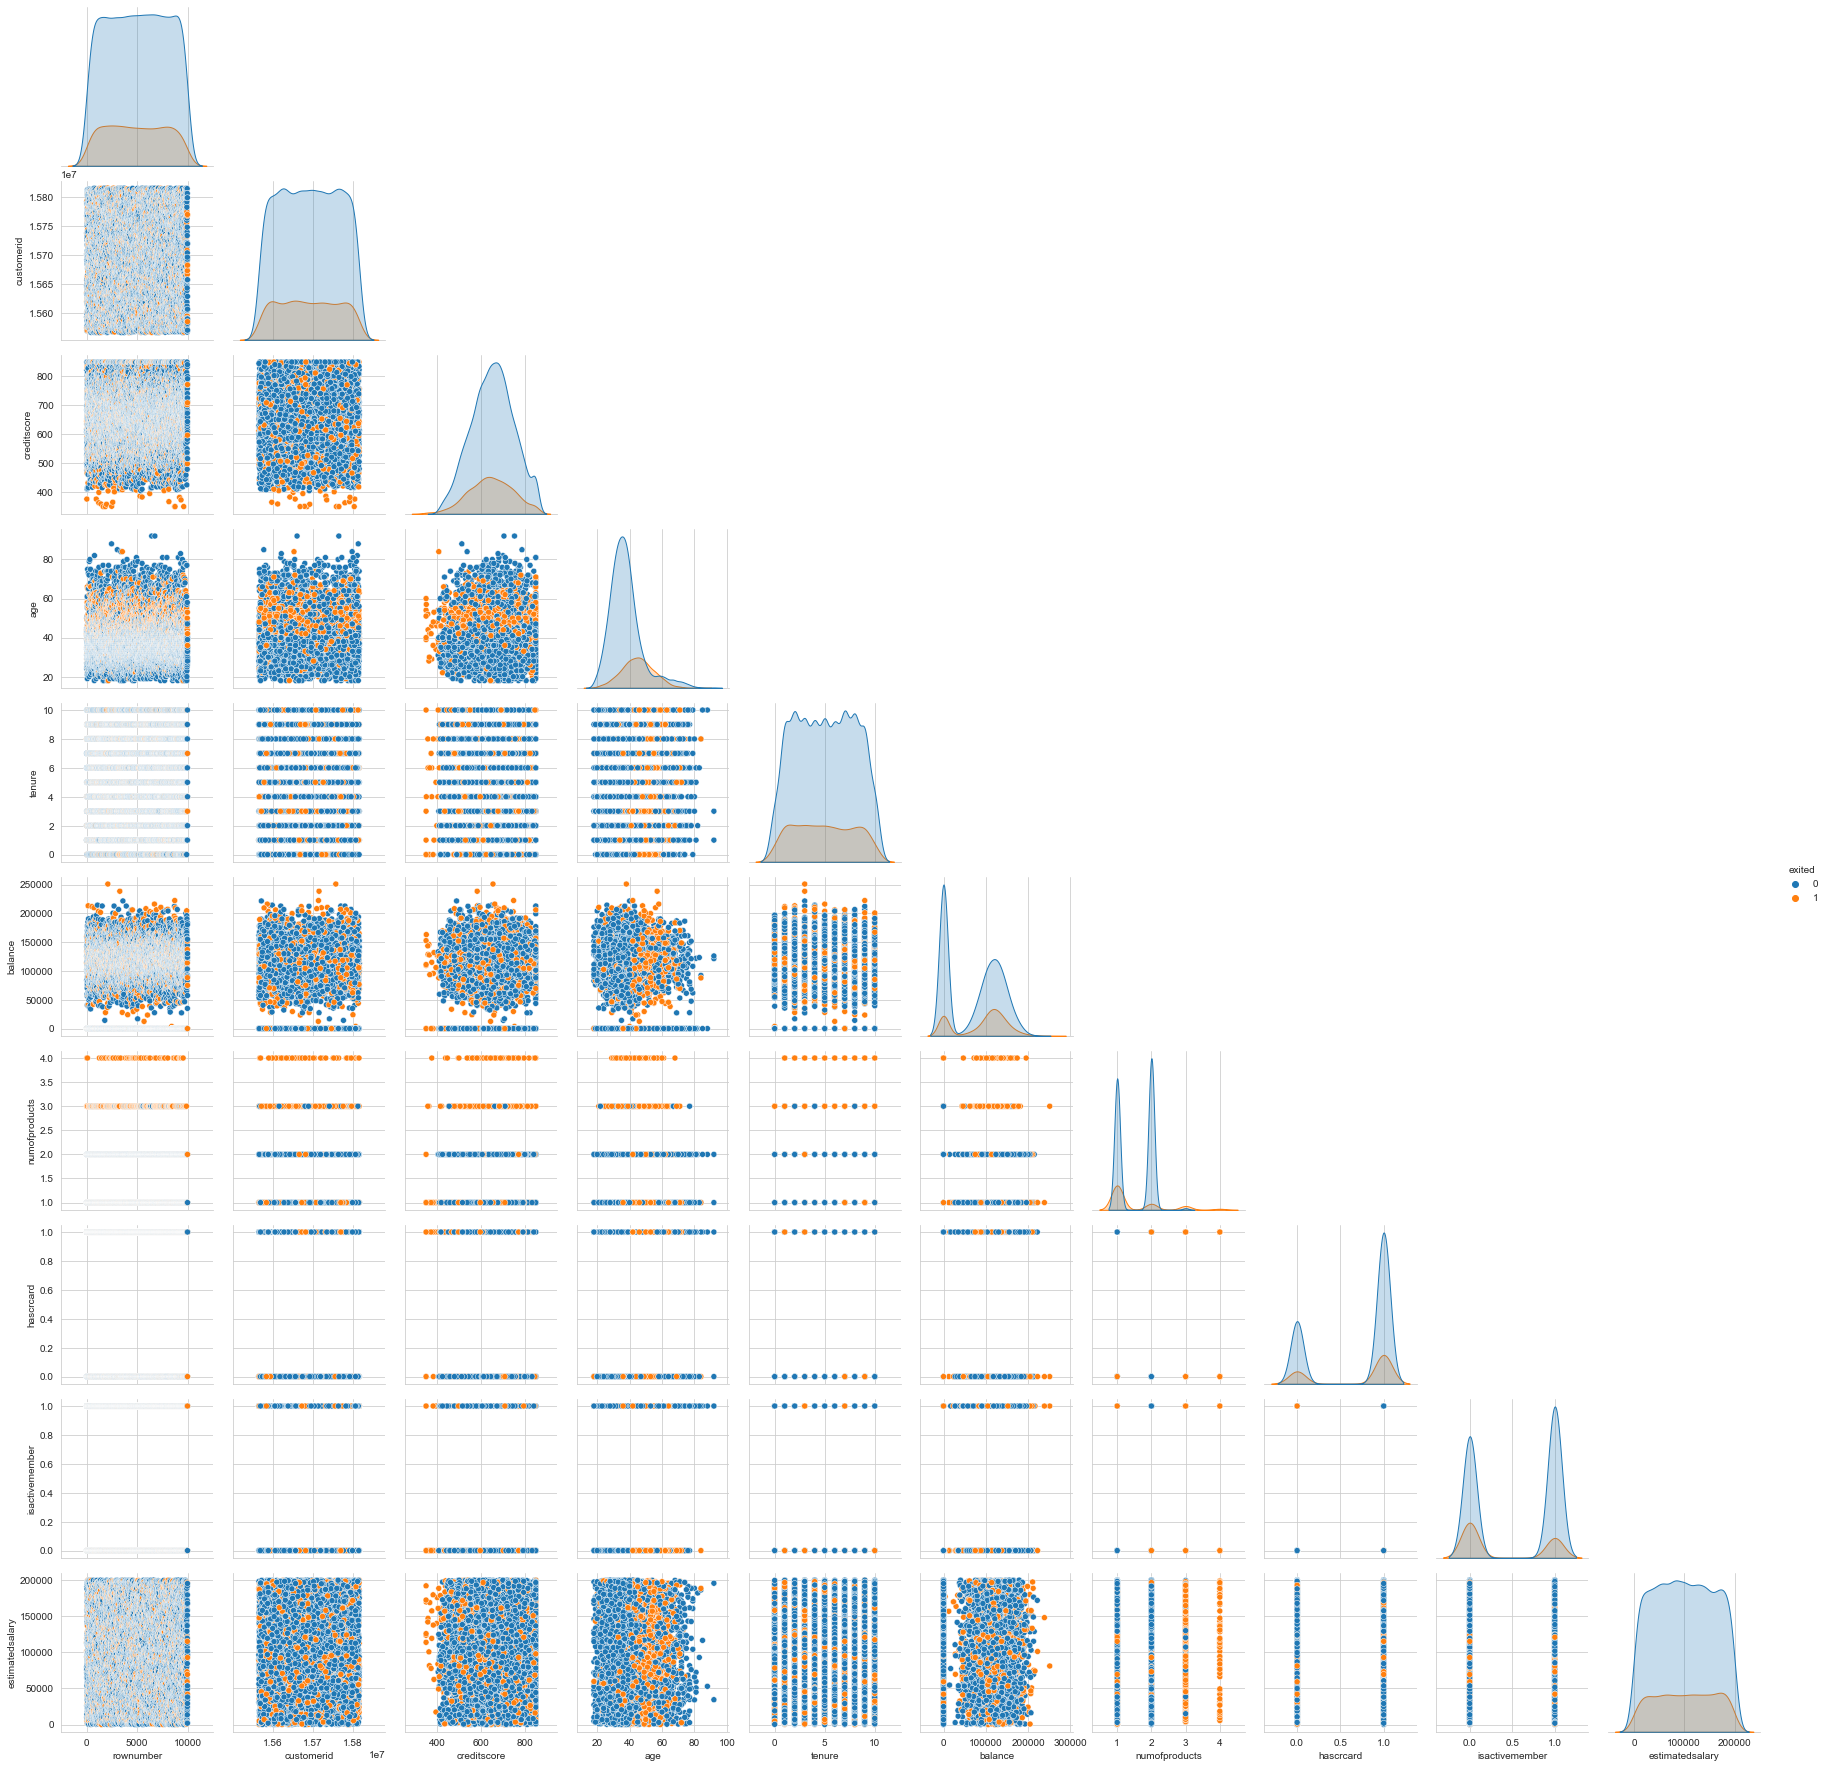

In [124]:
sns.pairplot(df, hue=target, corner=True);

In [127]:
df["tenure"].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: tenure, dtype: int64

In [137]:
df["tenure"].iplot(kind='histogram', subplots=True, bins=20, title = "Tenure Distribution", xTitle = "Tenure", yTitle = "Count")

### Examination of Categorical Columns

In [140]:
X_categorical.head(10).T

0       1       2       3         4      5         6  \
surname    Hargrave    Hill    Onio    Boni  Mitchell    Chu  Bartlett   
geography    France   Spain  France  France     Spain  Spain    France   
gender       Female  Female  Female  Female    Female   Male      Male   

                 7       8       9  
surname     Obinna      He      H?  
geography  Germany  France  France  
gender      Female    Male    Male

In [144]:
X_categorical_.describe().T

count unique     top  freq
geography  10000      3  France  5014
gender     10000      2    Male  5457

In [148]:
X_categorical_.iplot(kind='histogram', subplots=True, bins=10)

In [155]:
pd.crosstab(df["geography"], df["exited"])

exited        0    1
geography           
France     4204  810
Germany    1695  814
Spain      2064  413

In [156]:
 pd.crosstab(df["gender"], df["exited"])

exited     0     1
gender            
Female  3404  1139
Male    4559   898

In [157]:
df

rownumber  customerid    surname  creditscore geography  gender  age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      tenure   balance  numofproducts  hascrcard  isactivemember  \
0          2      0.00              1          1               1   
1          1  83807.86              1          0               1   
2          8 159660.80              3          1               0   
3          1      0.00              2          0               0   
4          2 125510.82              1          1               1   
...      ...       ...            ...        ...             ...   
9995       5      0.00              2          1               0   
9996      10  57369.61              1          1               1   
9997       7      0.00              1          0               1   
9998       3  75075.31              2          1               0   
9999       4 130142.79              1          1               0   

      estimatedsalary  exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

In [159]:
# sns.swarmplot(y="age", x="geography", hue="exited", data=df);

In [ ]:
# sns.swarmplot(y="gender", x="geography", hue="exited", data=df);

## Preprocessing of Data
- Train | Test Split, Scalling

In [58]:
df.head(5)

rownumber  customerid   surname  creditscore geography  gender  age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   tenure    balance  numofproducts  hascrcard  isactivemember  \
0       2      0.000              1          1               1   
1       1  83807.860              1          0               1   
2       8 159660.800              3          1               0   
3       1      0.000              2          0               0   
4       2 125510.820              1          1               1   

   estimatedsalary  exited  
0       101348.880       1  
1       112542.580       0  
2       113931.570       1  
3        93826.630       0  
4        79084.100       0

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [62]:
X_columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary'],
      dtype='object')

In [60]:
X_categorical

surname geography  gender
0      Hargrave    France  Female
1          Hill     Spain  Female
2          Onio    France  Female
3          Boni    France  Female
4      Mitchell     Spain  Female
...         ...       ...     ...
9995   Obijiaku    France    Male
9996  Johnstone    France    Male
9997        Liu    France  Female
9998  Sabbatini   Germany    Male
9999     Walker    France  Female

[10000 rows x 3 columns]

In [69]:
X_categorical["geography"].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [70]:
X_categorical["gender"].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [61]:
X_numerical

rownumber   customerid  creditscore    age  tenure    balance  \
0         1.000 15634602.000      619.000 42.000   2.000      0.000   
1         2.000 15647311.000      608.000 41.000   1.000  83807.860   
2         3.000 15619304.000      502.000 42.000   8.000 159660.800   
3         4.000 15701354.000      699.000 39.000   1.000      0.000   
4         5.000 15737888.000      850.000 43.000   2.000 125510.820   
...         ...          ...          ...    ...     ...        ...   
9995   9996.000 15606229.000      771.000 39.000   5.000      0.000   
9996   9997.000 15569892.000      516.000 35.000  10.000  57369.610   
9997   9998.000 15584532.000      709.000 36.000   7.000      0.000   
9998   9999.000 15682355.000      772.000 42.000   3.000  75075.310   
9999  10000.000 15628319.000      792.000 28.000   4.000 130142.790   

      numofproducts  hascrcard  isactivemember  estimatedsalary  
0             1.000      1.000           1.000       101348.880  
1             1.000      0.000           1.000       112542.580  
2             3.000      1.000           0.000       113931.570  
3             2.000      0.000           0.000        93826.630  
4             1.000      1.000           1.000        79084.100  
...             ...        ...             ...              ...  
9995          2.000      1.000           0.000        96270.640  
9996          1.000      1.000           1.000       101699.770  
9997          1.000      0.000           1.000        42085.580  
9998          2.000      1.000           0.000        92888.520  
9999          1.000      1.000           0.000        38190.780  

[10000 rows x 10 columns]

In [65]:
X_numerical["hascrcard"].value_counts()

1.000    7055
0.000    2945
Name: hascrcard, dtype: int64

In [66]:
X_numerical["numofproducts"].value_counts()

1.000    5084
2.000    4590
3.000     266
4.000      60
Name: numofproducts, dtype: int64

In [67]:
X_numerical["isactivemember"].value_counts()

1.000    5151
0.000    4849
Name: isactivemember, dtype: int64

In [179]:
# 10-Train|Test Split, Dummy 

# # Before dummy: 
# make_dtype_object = df[['categorical1','categorical2']].astype('object')

X_columns_ = df.drop(target, axis=1).columns
X_categorical_ = df.drop([target, "surname"], axis=1).select_dtypes('object')
X_numerical_ = df.drop([target,"rownumber", "customerid"], axis=1).select_dtypes('number').astype('float64')

###############################################################################

if (df.dtypes==object).any():
    dummied = pd.get_dummies(X_categorical_)
    X = pd.concat([X_numerical_, dummied[dummied.columns]], axis=1)
    
else:
    X = df.drop(target, axis=1).astype('float64')
try:
    if (df[target].dtypes==object).any():
        y = pd.get_dummies(df[target], drop_first=True)
    
except:
    y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10,
                                                    stratify = y,
                                                    random_state=42)

###############################################################################

# # 11-MinMax Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 11-Standart Scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

###############################################################################

In [180]:
X.head()

creditscore   age  tenure   balance  numofproducts  hascrcard  \
0       619.00 42.00    2.00      0.00           1.00       1.00   
1       608.00 41.00    1.00  83807.86           1.00       0.00   
2       502.00 42.00    8.00 159660.80           3.00       1.00   
3       699.00 39.00    1.00      0.00           2.00       0.00   
4       850.00 43.00    2.00 125510.82           1.00       1.00   

   isactivemember  estimatedsalary  geography_France  geography_Germany  \
0            1.00        101348.88                 1                  0   
1            1.00        112542.58                 0                  0   
2            0.00        113931.57                 1                  0   
3            0.00         93826.63                 1                  0   
4            1.00         79084.10                 0                  0   

   geography_Spain  gender_Female  gender_Male  
0                0              1            0  
1                1              1            0  
2                0              1            0  
3                0              1            0  
4                1              1            0

In [181]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: exited, dtype: int64

In [184]:
shape_control()

df.shape: (10000, 14)
X.shape: (10000, 13)
y.shape: (10000,)
X_train.shape: (9000, 13)
y_train.shape: (9000,)
X_test.shape: (1000, 13)
y_test.shape: (1000,)



## Modelling & Model Performance

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [176]:
model = Sequential()

model.add(Dense(30, activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [185]:
model.fit(x = X_train, y = y_train, validation_split = 0.1, batch_size = 32, epochs = 500, verbose=1)

Epoch 1/500
254/254 [==============================] - 2s 6ms/step - loss: 0.4833 - accuracy: 0.7942 - val_loss: 18.9723 - val_accuracy: 0.7589
Epoch 2/500
254/254 [==============================] - 2s 6ms/step - loss: 0.4711 - accuracy: 0.7974 - val_loss: 183.9029 - val_accuracy: 0.6900
Epoch 3/500
254/254 [==============================] - 2s 6ms/step - loss: 0.4645 - accuracy: 0.8019 - val_loss: 342.8971 - val_accuracy: 0.6522
Epoch 4/500
254/254 [==============================] - 2s 7ms/step - loss: 0.4603 - accuracy: 0.8016 - val_loss: 600.3552 - val_accuracy: 0.6178
Epoch 5/500
254/254 [==============================] - 2s 7ms/step - loss: 0.4558 - accuracy: 0.8011 - val_loss: 738.7696 - val_accuracy: 0.6133
Epoch 6/500
254/254 [==============================] - 2s 7ms/step - loss: 0.4519 - accuracy: 0.8062 - val_loss: 835.5457 - val_accuracy: 0.6067
Epoch 7/500
254/254 [==============================] - 2s 6ms/step - loss: 0.4475 - accuracy: 0.8070 - val_loss: 738.4902 - val_acc

Epoch 57/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3530 - accuracy: 0.8532 - val_loss: 10887.4844 - val_accuracy: 0.2533
Epoch 58/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3527 - accuracy: 0.8505 - val_loss: 10580.9951 - val_accuracy: 0.2611
Epoch 59/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3522 - accuracy: 0.8538 - val_loss: 10520.6025 - val_accuracy: 0.2389
Epoch 60/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3507 - accuracy: 0.8538 - val_loss: 11550.9189 - val_accuracy: 0.2344
Epoch 61/500
254/254 [==============================] - 1s 5ms/step - loss: 0.3510 - accuracy: 0.8525 - val_loss: 11482.7119 - val_accuracy: 0.2200
Epoch 62/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3509 - accuracy: 0.8531 - val_loss: 12068.0020 - val_accuracy: 0.2300
Epoch 63/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3523 - accuracy: 0.8532 - val_loss

254/254 [==============================] - 2s 6ms/step - loss: 0.3403 - accuracy: 0.8590 - val_loss: 38794.0547 - val_accuracy: 0.2033
Epoch 168/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3366 - accuracy: 0.8600 - val_loss: 42524.2188 - val_accuracy: 0.2022
Epoch 169/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3389 - accuracy: 0.8590 - val_loss: 44072.4805 - val_accuracy: 0.2022
Epoch 170/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3376 - accuracy: 0.8627 - val_loss: 46924.3008 - val_accuracy: 0.2022
Epoch 171/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3380 - accuracy: 0.8604 - val_loss: 49425.4531 - val_accuracy: 0.2011
Epoch 172/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3376 - accuracy: 0.8612 - val_loss: 49000.3086 - val_accuracy: 0.2022
Epoch 173/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3384 - accuracy: 0.8594 - val_loss: 47912

254/254 [==============================] - 2s 6ms/step - loss: 0.3326 - accuracy: 0.8641 - val_loss: 90903.3750 - val_accuracy: 0.2011
Epoch 223/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3333 - accuracy: 0.8633 - val_loss: 89936.1328 - val_accuracy: 0.2011
Epoch 224/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3334 - accuracy: 0.8646 - val_loss: 93332.8750 - val_accuracy: 0.2011
Epoch 225/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3351 - accuracy: 0.8614 - val_loss: 95951.6719 - val_accuracy: 0.2011
Epoch 226/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3340 - accuracy: 0.8632 - val_loss: 92392.2422 - val_accuracy: 0.2011
Epoch 227/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3344 - accuracy: 0.8627 - val_loss: 91681.6797 - val_accuracy: 0.2011
Epoch 228/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3337 - accuracy: 0.8635 - val_loss: 95921

Epoch 277/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3304 - accuracy: 0.8638 - val_loss: 131725.8281 - val_accuracy: 0.2011
Epoch 278/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3317 - accuracy: 0.8615 - val_loss: 130659.2969 - val_accuracy: 0.2011
Epoch 279/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3320 - accuracy: 0.8648 - val_loss: 125668.8125 - val_accuracy: 0.2011
Epoch 280/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3297 - accuracy: 0.8635 - val_loss: 140660.0312 - val_accuracy: 0.2011
Epoch 281/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3304 - accuracy: 0.8635 - val_loss: 136131.9219 - val_accuracy: 0.2011
Epoch 282/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3320 - accuracy: 0.8630 - val_loss: 132968.3125 - val_accuracy: 0.2011
Epoch 283/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.86

Epoch 386/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3264 - accuracy: 0.8662 - val_loss: 202427.5156 - val_accuracy: 0.2011
Epoch 387/500
254/254 [==============================] - 1s 6ms/step - loss: 0.3270 - accuracy: 0.8668 - val_loss: 211109.8594 - val_accuracy: 0.2011
Epoch 388/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3262 - accuracy: 0.8635 - val_loss: 200745.3750 - val_accuracy: 0.2011
Epoch 389/500
254/254 [==============================] - 2s 7ms/step - loss: 0.3253 - accuracy: 0.8662 - val_loss: 208561.1719 - val_accuracy: 0.2011
Epoch 390/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3256 - accuracy: 0.8657 - val_loss: 214993.1875 - val_accuracy: 0.2011
Epoch 391/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3264 - accuracy: 0.8664 - val_loss: 211019.0469 - val_accuracy: 0.2011
Epoch 392/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3257 - accuracy: 0.86

Epoch 495/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3223 - accuracy: 0.8688 - val_loss: 224428.0000 - val_accuracy: 0.2011
Epoch 496/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3223 - accuracy: 0.8673 - val_loss: 227692.5625 - val_accuracy: 0.2011
Epoch 497/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3215 - accuracy: 0.8672 - val_loss: 228300.1562 - val_accuracy: 0.2011
Epoch 498/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3211 - accuracy: 0.8696 - val_loss: 221968.5625 - val_accuracy: 0.2011
Epoch 499/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3220 - accuracy: 0.8693 - val_loss: 221891.2344 - val_accuracy: 0.2011
Epoch 500/500
254/254 [==============================] - 2s 6ms/step - loss: 0.3221 - accuracy: 0.8673 - val_loss: 229837.9688 - val_accuracy: 0.2011


In [186]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 26)                364       
_________________________________________________________________
dense_4 (Dense)              (None, 13)                351       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 14        
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________


In [187]:
loss_df = pd.DataFrame(model.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0  0.48      0.79     18.97          0.76
1  0.47      0.80    183.90          0.69
2  0.46      0.80    342.90          0.65
3  0.46      0.80    600.36          0.62
4  0.46      0.80    738.77          0.61

In [188]:
loss_df.sort_values(by="val_accuracy", ascending=False).nlargest(10, "val_accuracy")

loss  accuracy  val_loss  val_accuracy
0   0.48      0.79     18.97          0.76
14  0.41      0.83    320.71          0.70
17  0.41      0.83    340.29          0.70
16  0.41      0.83    234.88          0.69
15  0.41      0.83    234.82          0.69
1   0.47      0.80    183.90          0.69
9   0.43      0.82    283.37          0.69
10  0.42      0.82    257.27          0.69
11  0.42      0.82    236.85          0.69
12  0.42      0.82    296.96          0.69

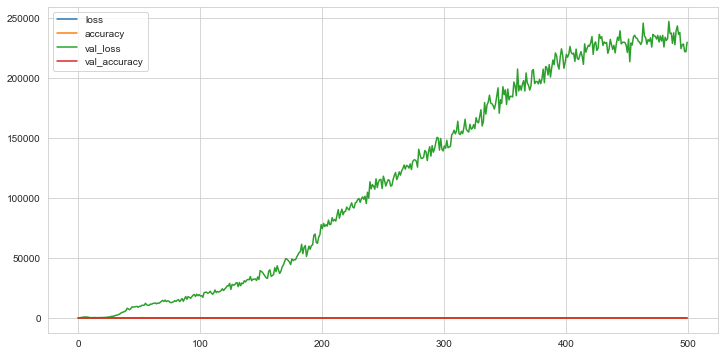

In [189]:
loss_df.plot();

In [190]:
model.evaluate(X_test, y_test, verbose=0)

[0.3500024080276489, 0.847000002861023]

In [191]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss : ", loss)
print("accuracy : ", accuracy)

loss :  0.3500024080276489
accuracy :  0.847000002861023


In [201]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[772  24]
 [115  89]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       796
           1       0.79      0.44      0.56       204

    accuracy                           0.86      1000
   macro avg       0.83      0.70      0.74      1000
weighted avg       0.85      0.86      0.84      1000



### EarlyStopping

In [193]:
from tensorflow.keras.callbacks import EarlyStopping

In [194]:
model = Sequential()

model.add(Dense(30, activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [195]:
#The patience is often set somewhere between 10 and 100 (10 or 20 is more common), 
#but it really depends on your dataset and network.

In [196]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "auto", verbose = 1, patience = 40)

In [197]:
model.fit(x = X_train, y = y_train, validation_split = 0.1, batch_size = 32, epochs = 1000, verbose = 1,
          callbacks = [early_stop])

Epoch 1/1000
254/254 [==============================] - 3s 6ms/step - loss: 0.4804 - accuracy: 0.7960 - val_loss: 0.4496 - val_accuracy: 0.7989
Epoch 2/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.4564 - accuracy: 0.7962 - val_loss: 0.4327 - val_accuracy: 0.8011
Epoch 3/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.4373 - accuracy: 0.8069 - val_loss: 0.4029 - val_accuracy: 0.8289
Epoch 4/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8152 - val_loss: 0.3979 - val_accuracy: 0.8489
Epoch 5/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.4076 - accuracy: 0.8209 - val_loss: 0.3718 - val_accuracy: 0.8556
Epoch 6/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3978 - accuracy: 0.8269 - val_loss: 0.3608 - val_accuracy: 0.8589
Epoch 7/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3876 - accuracy: 0.8333 - val_loss: 0.3458 - val_accuracy:

254/254 [==============================] - 1s 4ms/step - loss: 0.3246 - accuracy: 0.8648 - val_loss: 0.3006 - val_accuracy: 0.8956
Epoch 114/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3234 - accuracy: 0.8638 - val_loss: 0.2876 - val_accuracy: 0.8944
Epoch 115/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3238 - accuracy: 0.8616 - val_loss: 0.2949 - val_accuracy: 0.8856
Epoch 116/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3231 - accuracy: 0.8642 - val_loss: 0.2914 - val_accuracy: 0.8878
Epoch 117/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3239 - accuracy: 0.8628 - val_loss: 0.2908 - val_accuracy: 0.8822
Epoch 118/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3231 - accuracy: 0.8625 - val_loss: 0.2900 - val_accuracy: 0.8889
Epoch 119/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3222 - accuracy: 0.8647 - val_loss: 0.2876 - val_accuracy: 

In [198]:
loss_df.sort_values(by="val_accuracy", ascending=False).nlargest(10, "val_accuracy")

loss  accuracy  val_loss  val_accuracy
0   0.48      0.79     18.97          0.76
14  0.41      0.83    320.71          0.70
17  0.41      0.83    340.29          0.70
16  0.41      0.83    234.88          0.69
15  0.41      0.83    234.82          0.69
1   0.47      0.80    183.90          0.69
9   0.43      0.82    283.37          0.69
10  0.42      0.82    257.27          0.69
11  0.42      0.82    236.85          0.69
12  0.42      0.82    296.96          0.69

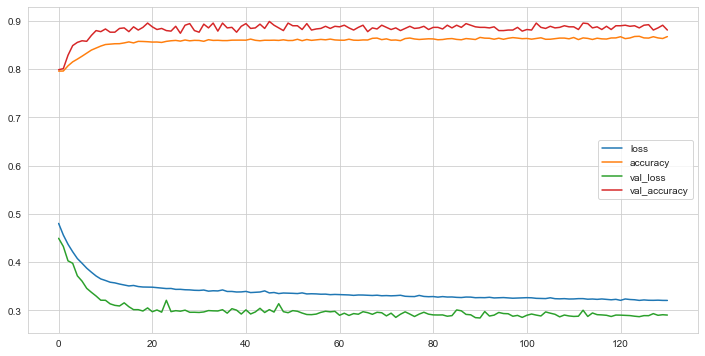

In [199]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

In [202]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[772  24]
 [115  89]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       796
           1       0.79      0.44      0.56       204

    accuracy                           0.86      1000
   macro avg       0.83      0.70      0.74      1000
weighted avg       0.85      0.86      0.84      1000



### learning_rate

In [203]:
from tensorflow.keras.optimizers import Adam

In [204]:
model = Sequential()

model.add(Dense(30, activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

opt = Adam(lr = 0.005)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [205]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "auto", verbose = 1, patience = 15)

In [206]:
model.fit(x = X_train, y = y_train, validation_split = 0.1, batch_size = 32, epochs = 1000, verbose = 1,
          callbacks = [early_stop])

Epoch 1/1000
254/254 [==============================] - 3s 6ms/step - loss: 0.4652 - accuracy: 0.8002 - val_loss: 0.4428 - val_accuracy: 0.8222
Epoch 2/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.4296 - accuracy: 0.8178 - val_loss: 0.3894 - val_accuracy: 0.8578
Epoch 3/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.4026 - accuracy: 0.8248 - val_loss: 0.3481 - val_accuracy: 0.8644
Epoch 4/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3849 - accuracy: 0.8386 - val_loss: 0.3225 - val_accuracy: 0.8889
Epoch 5/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3688 - accuracy: 0.8433 - val_loss: 0.3377 - val_accuracy: 0.8789
Epoch 6/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3620 - accuracy: 0.8485 - val_loss: 0.3218 - val_accuracy: 0.8900
Epoch 7/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3570 - accuracy: 0.8504 - val_loss: 0.3118 - val_accuracy:

<AxesSubplot:>

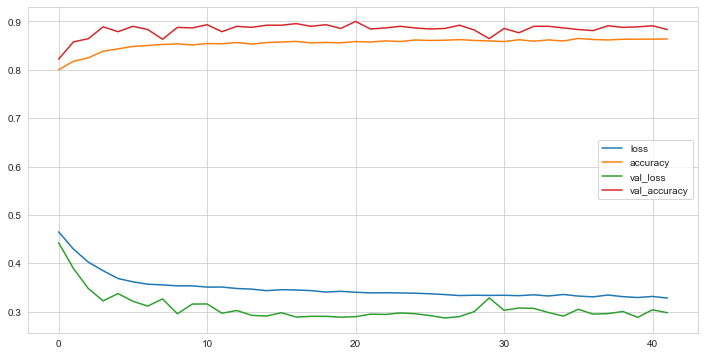

In [207]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [208]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[770  26]
 [117  87]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       796
           1       0.77      0.43      0.55       204

    accuracy                           0.86      1000
   macro avg       0.82      0.70      0.73      1000
weighted avg       0.85      0.86      0.84      1000



### Dropout

The Dropout layer randomly sets input units to 0 with a frequency of `rate`
at each step during training time, which helps prevent overfitting.

In [209]:
from tensorflow.keras.layers import Dropout

In [210]:
model = Sequential()

model.add(Dense(30, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr = 0.001)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [211]:
model.fit(x = X_train, y = y_train, validation_split = 0.1, batch_size = 32, epochs = 1000, verbose = 1)

Epoch 1/1000
254/254 [==============================] - 3s 6ms/step - loss: 0.5872 - accuracy: 0.7325 - val_loss: 0.4882 - val_accuracy: 0.7989
Epoch 2/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.5202 - accuracy: 0.7947 - val_loss: 0.4696 - val_accuracy: 0.7989
Epoch 3/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.5044 - accuracy: 0.7962 - val_loss: 0.4598 - val_accuracy: 0.7989
Epoch 4/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.4877 - accuracy: 0.7964 - val_loss: 0.4525 - val_accuracy: 0.7989
Epoch 5/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.4854 - accuracy: 0.7975 - val_loss: 0.4432 - val_accuracy: 0.7989
Epoch 6/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.4783 - accuracy: 0.7967 - val_loss: 0.4396 - val_accuracy: 0.7989
Epoch 7/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.4703 - accuracy: 0.8000 - val_loss: 0.4341 - val_accuracy:

254/254 [==============================] - 1s 5ms/step - loss: 0.3792 - accuracy: 0.8454 - val_loss: 0.3049 - val_accuracy: 0.8811
Epoch 114/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3720 - accuracy: 0.8468 - val_loss: 0.2995 - val_accuracy: 0.8811
Epoch 115/1000
254/254 [==============================] - 1s 6ms/step - loss: 0.3820 - accuracy: 0.8425 - val_loss: 0.3029 - val_accuracy: 0.8867
Epoch 116/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3698 - accuracy: 0.8480 - val_loss: 0.3008 - val_accuracy: 0.8922
Epoch 117/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3762 - accuracy: 0.8468 - val_loss: 0.3063 - val_accuracy: 0.8833
Epoch 118/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3777 - accuracy: 0.8441 - val_loss: 0.3061 - val_accuracy: 0.8811
Epoch 119/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3751 - accuracy: 0.8452 - val_loss: 0.3055 - val_accuracy: 

254/254 [==============================] - 1s 5ms/step - loss: 0.3642 - accuracy: 0.8509 - val_loss: 0.2975 - val_accuracy: 0.8856
Epoch 226/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3711 - accuracy: 0.8473 - val_loss: 0.2996 - val_accuracy: 0.8867
Epoch 227/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3803 - accuracy: 0.8460 - val_loss: 0.2918 - val_accuracy: 0.8856
Epoch 228/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3757 - accuracy: 0.8433 - val_loss: 0.2914 - val_accuracy: 0.8811
Epoch 229/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3691 - accuracy: 0.8484 - val_loss: 0.2965 - val_accuracy: 0.8856
Epoch 230/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3742 - accuracy: 0.8467 - val_loss: 0.2990 - val_accuracy: 0.8811
Epoch 231/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3707 - accuracy: 0.8448 - val_loss: 0.2986 - val_accuracy: 

254/254 [==============================] - 1s 5ms/step - loss: 0.3682 - accuracy: 0.8473 - val_loss: 0.2980 - val_accuracy: 0.8789
Epoch 338/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3673 - accuracy: 0.8462 - val_loss: 0.2979 - val_accuracy: 0.8833
Epoch 339/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3721 - accuracy: 0.8458 - val_loss: 0.2943 - val_accuracy: 0.8844
Epoch 340/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3701 - accuracy: 0.8496 - val_loss: 0.2996 - val_accuracy: 0.8856
Epoch 341/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3647 - accuracy: 0.8509 - val_loss: 0.2919 - val_accuracy: 0.8889
Epoch 342/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3701 - accuracy: 0.8504 - val_loss: 0.2982 - val_accuracy: 0.8811
Epoch 343/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3754 - accuracy: 0.8432 - val_loss: 0.2980 - val_accuracy: 

254/254 [==============================] - 1s 5ms/step - loss: 0.3699 - accuracy: 0.8484 - val_loss: 0.3016 - val_accuracy: 0.8844
Epoch 450/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3704 - accuracy: 0.8414 - val_loss: 0.2988 - val_accuracy: 0.8811
Epoch 451/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3718 - accuracy: 0.8472 - val_loss: 0.2971 - val_accuracy: 0.8878
Epoch 452/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3706 - accuracy: 0.8470 - val_loss: 0.3001 - val_accuracy: 0.8811
Epoch 453/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3641 - accuracy: 0.8474 - val_loss: 0.2926 - val_accuracy: 0.8867
Epoch 454/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.8483 - val_loss: 0.2962 - val_accuracy: 0.8822
Epoch 455/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3695 - accuracy: 0.8472 - val_loss: 0.2943 - val_accuracy: 

254/254 [==============================] - 1s 5ms/step - loss: 0.3749 - accuracy: 0.8443 - val_loss: 0.2998 - val_accuracy: 0.8811
Epoch 562/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3645 - accuracy: 0.8496 - val_loss: 0.2908 - val_accuracy: 0.8878
Epoch 563/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3694 - accuracy: 0.8507 - val_loss: 0.2982 - val_accuracy: 0.8833
Epoch 564/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3676 - accuracy: 0.8496 - val_loss: 0.2998 - val_accuracy: 0.8778
Epoch 565/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3635 - accuracy: 0.8521 - val_loss: 0.3018 - val_accuracy: 0.8811
Epoch 566/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3704 - accuracy: 0.8484 - val_loss: 0.3010 - val_accuracy: 0.8811
Epoch 567/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3669 - accuracy: 0.8453 - val_loss: 0.2997 - val_accuracy: 

Epoch 617/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3671 - accuracy: 0.8468 - val_loss: 0.2960 - val_accuracy: 0.8822
Epoch 618/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3708 - accuracy: 0.8459 - val_loss: 0.2957 - val_accuracy: 0.8844
Epoch 619/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3643 - accuracy: 0.8506 - val_loss: 0.2974 - val_accuracy: 0.8800
Epoch 620/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3644 - accuracy: 0.8481 - val_loss: 0.2962 - val_accuracy: 0.8833
Epoch 621/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3688 - accuracy: 0.8485 - val_loss: 0.2995 - val_accuracy: 0.8867
Epoch 622/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3686 - accuracy: 0.8473 - val_loss: 0.2960 - val_accuracy: 0.8833
Epoch 623/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3690 - accuracy: 0.8474 - val_loss: 0.2988 -

254/254 [==============================] - 1s 5ms/step - loss: 0.3647 - accuracy: 0.8501 - val_loss: 0.2986 - val_accuracy: 0.8800
Epoch 730/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3636 - accuracy: 0.8478 - val_loss: 0.2979 - val_accuracy: 0.8789
Epoch 731/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3683 - accuracy: 0.8459 - val_loss: 0.2959 - val_accuracy: 0.8844
Epoch 732/1000
254/254 [==============================] - 1s 5ms/step - loss: 0.3654 - accuracy: 0.8464 - val_loss: 0.2959 - val_accuracy: 0.8822
Epoch 733/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3673 - accuracy: 0.8501 - val_loss: 0.2936 - val_accuracy: 0.8800
Epoch 734/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3668 - accuracy: 0.8517 - val_loss: 0.2966 - val_accuracy: 0.8833
Epoch 735/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3724 - accuracy: 0.8463 - val_loss: 0.2982 - val_accuracy: 

254/254 [==============================] - 1s 4ms/step - loss: 0.3633 - accuracy: 0.8490 - val_loss: 0.3021 - val_accuracy: 0.8856
Epoch 842/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3631 - accuracy: 0.8514 - val_loss: 0.2961 - val_accuracy: 0.8822
Epoch 843/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3654 - accuracy: 0.8502 - val_loss: 0.2962 - val_accuracy: 0.8822
Epoch 844/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3637 - accuracy: 0.8530 - val_loss: 0.2945 - val_accuracy: 0.8822
Epoch 845/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3671 - accuracy: 0.8478 - val_loss: 0.2969 - val_accuracy: 0.8789
Epoch 846/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.8479 - val_loss: 0.2970 - val_accuracy: 0.8800
Epoch 847/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3722 - accuracy: 0.8460 - val_loss: 0.3003 - val_accuracy: 

254/254 [==============================] - 1s 4ms/step - loss: 0.3659 - accuracy: 0.8489 - val_loss: 0.2948 - val_accuracy: 0.8822
Epoch 954/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3679 - accuracy: 0.8481 - val_loss: 0.2989 - val_accuracy: 0.8822
Epoch 955/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3639 - accuracy: 0.8454 - val_loss: 0.2996 - val_accuracy: 0.8800
Epoch 956/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3653 - accuracy: 0.8523 - val_loss: 0.2971 - val_accuracy: 0.8811
Epoch 957/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3722 - accuracy: 0.8467 - val_loss: 0.2966 - val_accuracy: 0.8822
Epoch 958/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3658 - accuracy: 0.8484 - val_loss: 0.2951 - val_accuracy: 0.8878
Epoch 959/1000
254/254 [==============================] - 1s 4ms/step - loss: 0.3623 - accuracy: 0.8475 - val_loss: 0.2981 - val_accuracy: 

In [212]:
loss_df.sort_values(by="val_accuracy", ascending=False).nlargest(10, "val_accuracy")

loss  accuracy  val_loss  val_accuracy
20  0.34      0.86      0.29          0.90
16  0.35      0.86      0.29          0.90
18  0.34      0.86      0.29          0.89
10  0.35      0.85      0.32          0.89
15  0.35      0.86      0.30          0.89
14  0.34      0.86      0.29          0.89
27  0.33      0.86      0.29          0.89
40  0.33      0.86      0.30          0.89
37  0.33      0.86      0.30          0.89
33  0.33      0.86      0.30          0.89

In [213]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002529AE4C748>>

<AxesSubplot:>

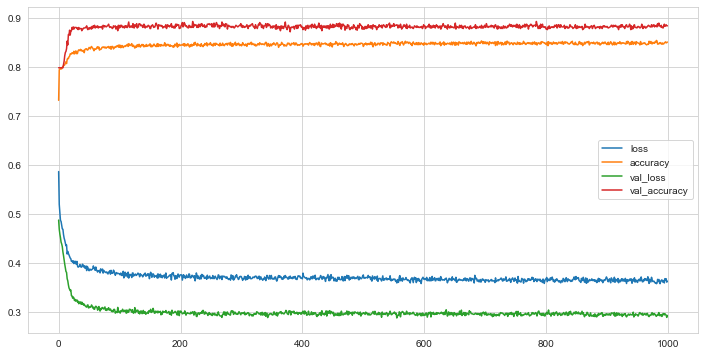

In [214]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [215]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
#y_test_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[772  24]
 [119  85]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       796
           1       0.78      0.42      0.54       204

    accuracy                           0.86      1000
   macro avg       0.82      0.69      0.73      1000
weighted avg       0.85      0.86      0.84      1000



## Cross Validation

In [216]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [217]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 30, activation = 'relu'))
    classifier.add(Dense(units = 15, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    classifier.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [218]:
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 32, epochs = 100, verbose=0)

scores = cross_validate(estimator = classifier, X = X_train, y = y_train,
                        scoring = ['accuracy', 'precision', 'recall', 'f1'], cv = 10)

df_scores = pd.DataFrame(scores, index = range(1, 11)).iloc[:, 2:]

df_scores_summary = pd.DataFrame({"score_mean" : df_scores.mean().values, "score_std" : df_scores.std().values},
                                 index = ["acc", "pre", "rec", "f1"])

df_scores_summary

score_mean  score_std
acc        0.86       0.01
pre        0.74       0.05
rec        0.47       0.06
f1         0.57       0.04

## GridSearchCV

In [219]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 30, activation = 'relu'))
    classifier.add(Dense(units = 15, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [220]:
early_stop = EarlyStopping(monitor = "accuracy", mode = "auto", verbose = 1, patience = 15)

In [ ]:
classifier = KerasClassifier(build_fn = build_classifier, epochs = 500)
parameters = {'batch_size': [32, 64, 128],
              'optimizer': ['adam', 'rmsprop', "SGD", "adagrad", "adadelta"]}
grid_model = GridSearchCV(estimator = classifier,
                          param_grid = parameters,
                          scoring = 'accuracy',
                          cv = 10,
                          n_jobs = -1,
                          verbose = 1)
grid_model.fit(X_train, y_train, callbacks = [early_stop])

Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [ ]:
loss_df.sort_values(by="val_accuracy", ascending=False).nlargest(10, "val_accuracy")

In [ ]:
grid_model.best_score_

In [ ]:
grid_model.best_params_

### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

#### for keras models

In [ ]:
y_test_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
roc_auc_score(y_test, y_test_pred_proba)

#### for gridsearchcv model

In [ ]:
y_test_pred_proba = grid_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='ANN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [ ]:
roc_auc_score(y_test, y_test_pred_proba)

### with class_weigth

Investigate how the "class_weight" hyper-parameter is used in a Neural Network.

- https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758
- https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [ ]:
from sklearn.utils import class_weight

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)

In [ ]:
class_weights

In [909]:
model_weighted = Sequential()

model_weighted.add(Dense(30, activation = "relu"))  # genelde hidden layer larda RELU kullanılır. Çünkü öğrenme daha hızlı olur.
model_weighted.add(Dense(15, activation = "relu"))
model_weighted.add(Dense(1, activation = "sigmoid"))  # binary vlassification olduğu için output layer da tek nöron olmak zorunda
                                             # SIGMOID datayı 0-1 arasına sıkıştırdığından tercih ettik. Binary Classification prob

opt = Adam(lr = 0.005)
model_weighted.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [910]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "auto", verbose = 1, patience = 20)

In [911]:
class_weight = {0: 0.62787777, 1: 2.45499182}           # class_weight = {0: 0.20, 1: 0.80}

In [912]:
model_weighted.fit(x = X_train, y = y_train, validation_split = 0.1, batch_size = 32, epochs = 1000, verbose=1,
                   callbacks = [early_stop], class_weight=class_weight)

Epoch 1/1000
254/254 [==============================] - 13s 21ms/step - loss: 0.6285 - accuracy: 0.6548 - val_loss: 0.6304 - val_accuracy: 0.6533
Epoch 2/1000
254/254 [==============================] - 4s 16ms/step - loss: 0.5739 - accuracy: 0.7027 - val_loss: 0.5417 - val_accuracy: 0.7456
Epoch 3/1000
254/254 [==============================] - 3s 13ms/step - loss: 0.5209 - accuracy: 0.7419 - val_loss: 0.4738 - val_accuracy: 0.7822
Epoch 4/1000
254/254 [==============================] - 3s 12ms/step - loss: 0.4983 - accuracy: 0.7531 - val_loss: 0.4102 - val_accuracy: 0.8178
Epoch 5/1000
254/254 [==============================] - 3s 13ms/step - loss: 0.4934 - accuracy: 0.7585 - val_loss: 0.4700 - val_accuracy: 0.7833
Epoch 6/1000
254/254 [==============================] - 3s 13ms/step - loss: 0.4881 - accuracy: 0.7726 - val_loss: 0.4875 - val_accuracy: 0.7744
Epoch 7/1000
254/254 [==============================] - 3s 13ms/step - loss: 0.4822 - accuracy: 0.7719 - val_loss: 0.5247 - val_a

In [913]:
model_weighted.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 32)                448       
_________________________________________________________________
dense_111 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 17        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss_df.sort_values(by="val_accuracy", ascending=False).nlargest(10, "val_accuracy")

In [914]:
loss_df = pd.DataFrame(model_weighted.history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy
0 0.629     0.655     0.630         0.653
1 0.574     0.703     0.542         0.746
2 0.521     0.742     0.474         0.782
3 0.498     0.753     0.410         0.818
4 0.493     0.759     0.470         0.783

In [915]:
loss_df = pd.DataFrame(model_weighted.history.history)
loss_df.tail()

loss  accuracy  val_loss  val_accuracy
27 0.449     0.798     0.446         0.802
28 0.448     0.799     0.453         0.794
29 0.446     0.794     0.455         0.796
30 0.446     0.800     0.457         0.792
31 0.444     0.802     0.483         0.777

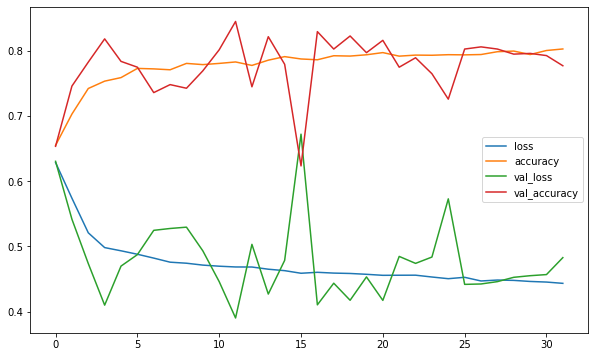

In [916]:
loss_df.plot();

#### Evaluate

In [917]:
model_weighted.evaluate(X_test, y_test, verbose=0)

[0.45762911438941956, 0.7879999876022339]

In [918]:
loss, accuracy = model_weighted.evaluate(X_test, y_test, verbose=0)
print("loss : ", loss)
print("accuracy : ", accuracy)

loss :  0.45762911438941956
accuracy :  0.7879999876022339


In [919]:
y_test_pred = (model_weighted.predict(X_test) > 0.5).astype("int32")
#y_test_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[633 163]
 [ 49 155]]
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       796
           1       0.49      0.76      0.59       204

    accuracy                           0.79      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.79      0.80      1000



## Saving Final Model and Scaler

In [929]:
import pickle
pickle.dump(scaler, open("scaler_exited", 'wb'))

In [930]:
final_model = Sequential()

final_model.add(Dense(30, activation = "relu"))  # genelde hidden layer larda RELU kullanılır. Çünkü öğrenme daha hızlı olur.
final_model.add(Dense(15, activation = "relu"))
final_model.add(Dense(1, activation = "sigmoid"))  # binary vlassification olduğu için output layer da tek nöron olmak zorunda
                                             # SIGMOID datayı 0-1 arasına sıkıştırdığından tercih ettik. Binary Classification prob

opt = Adam(lr = 0.005)
final_model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [931]:
early_stop = EarlyStopping(monitor = "val_loss", mode = "auto", verbose = 1, patience = 20)

In [932]:
class_weight = {0: 0.62787777, 1: 2.45499182}

In [933]:
final_model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 1000, verbose = 1,
                callbacks = [early_stop], class_weight = class_weight)

Epoch 1/1000
282/282 [==============================] - 13s 22ms/step - loss: 0.6107 - accuracy: 0.6699 - val_loss: 0.7154 - val_accuracy: 0.5960
Epoch 2/1000
282/282 [==============================] - 4s 14ms/step - loss: 0.5452 - accuracy: 0.7272 - val_loss: 0.5364 - val_accuracy: 0.7170ss: 0.5784 - accuracy - ETA: 3s - loss: 0.5821 -  - ETA: 2s - loss: 0.5659  - ETA:  - ETA: 0s - loss: 0.5537 - accuracy: 0.71 - ETA: 0s - l
Epoch 3/1000
282/282 [==============================] - 4s 13ms/step - loss: 0.5017 - accuracy: 0.7531 - val_loss: 0.4470 - val_accuracy: 0.8120
Epoch 4/1000
282/282 [==============================] - 4s 15ms/step - loss: 0.4895 - accuracy: 0.7609 - val_loss: 0.4416 - val_accuracy: 0.8080- loss: 0.4889 - accuracy: 
Epoch 5/1000
282/282 [==============================] - 4s 15ms/step - loss: 0.4829 - accuracy: 0.7678 - val_loss: 0.4935 - val_accuracy: 0.7570
Epoch 6/1000
282/282 [==============================] - 4s 15ms/step - loss: 0.4790 - accuracy: 0.7736 - val

<AxesSubplot:>

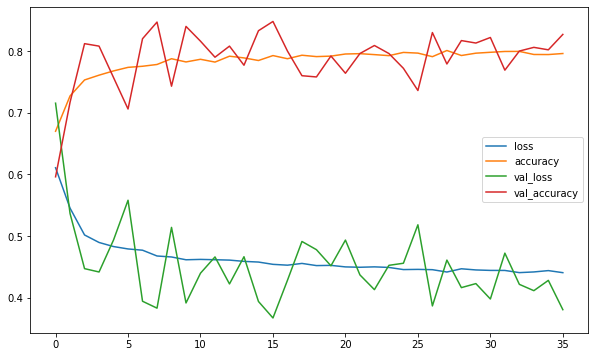

In [934]:
loss_df = pd.DataFrame(final_model.history.history)
loss_df.plot()

In [935]:
y_test_pred = (final_model.predict(X_test) > 0.5).astype("int32")
#y_test_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

[[681 115]
 [ 58 146]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       796
           1       0.56      0.72      0.63       204

    accuracy                           0.83      1000
   macro avg       0.74      0.79      0.76      1000
weighted avg       0.85      0.83      0.83      1000



In [936]:
model.save('model_exited.h5')

### Loading Model and Scaler

In [937]:
from tensorflow.keras.models import load_model

In [938]:
model_exited = load_model('model_exited.h5')
scaler_exited = pickle.load(open("scaler_exited", "rb"))

### Prediction

In [948]:
first_ten= df.drop(target, axis = 1).iloc[0:10, :]
first_ten

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2      0.000              1          1   
1          608   41       1  83807.860              1          0   
2          502   42       8 159660.800              3          1   
3          699   39       1      0.000              2          0   
4          850   43       2 125510.820              1          1   
5          645   44       8 113755.780              2          1   
6          822   50       7      0.000              2          1   
7          376   29       4 115046.740              4          1   
8          501   44       4 142051.070              2          0   
9          684   27       2 134603.880              1          1   

   IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany  \
0               1       101348.880                 1                  0   
1               1       112542.580                 0                  0   
2               0       113931.570                 1                  0   
3               0        93826.630                 1                  0   
4               1        79084.100                 0                  0   
5               0       149756.710                 0                  0   
6               1        10062.800                 1                  0   
7               0       119346.880                 0                  1   
8               1        74940.500                 1                  0   
9               1        71725.730                 1                  0   

   Geography_Spain  Gender_Female  Gender_Male  
0                0              1            0  
1                1              1            0  
2                0              1            0  
3                0              1            0  
4                1              1            0  
5                1              0            1  
6                0              0            1  
7                0              1            0  
8                0              0            1  
9                0              0            1

In [949]:
first_ten = scaler_exited.transform(first_ten)
first_ten

array([[0.538     , 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 1.        , 0.        ,
        0.        , 1.        , 0.        ],
       [0.516     , 0.31081081, 0.1       , 0.33403148, 0.        ,
        0.        , 1.        , 0.56270874, 0.        , 0.        ,
        1.        , 1.        , 0.        ],
       [0.304     , 0.32432432, 0.8       , 0.63635718, 0.66666667,
        1.        , 0.        , 0.56965435, 1.        , 0.        ,
        0.        , 1.        , 0.        ],
       [0.698     , 0.28378378, 0.1       , 0.        , 0.33333333,
        0.        , 0.        , 0.46912005, 1.        , 0.        ,
        0.        , 1.        , 0.        ],
       [1.        , 0.33783784, 0.2       , 0.50024622, 0.        ,
        1.        , 1.        , 0.39540036, 0.        , 0.        ,
        1.        , 1.        , 0.        ],
       [0.59      , 0.35135135, 0.8       , 0.45339436, 0.33333333,
        1.        , 0.     

In [950]:
(model_exited.predict(first_ten) > 0.5).astype("int32")

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0]])

In [951]:
df[target].iloc[0:10]

0    1
1    0
2    1
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: Exited, dtype: int64

## Comparison with ML

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_model=LogisticRegression()
log_model.fit(X_train, y_train)
y_test_pred = log_model.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))